In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import hog
from multiprocessing import Pool
from sklearn.metrics import confusion_matrix

# A. Importar datos

Los datos vienen en un archivo **.json**, con la siguientes llaves:

- `data`: list of list[int], imagenes 80x80 RGB, las imagenes estan aplanadas en un vector de dimensión 19200 (80x80x3),  las primeras 6400 entradas contienen los valores del canal rojo, las siguientes 6400 del verde, y las últimas 6400 del azul. La imagen es almacenada en orden fila, asi las primeras 80 entradas del arreglo son los valores del canal rojo de la primera fila de la imagen.
- `labels`: list of int, etiquetas de las imágenes, donde 1->"ship", 0->"no-ship".
- `locations`**(irrelevante)**: list of tuples, coordenadas geográficas, longitud y latitude del punto central de cada imágen.
- `scene_ids`: list, identificador único de cada imágen.


In [3]:
# cargar datos
with open("shipsnet.json", "r") as f:
    dataset = json.load(f)
f.close()
print(dataset.keys())

dict_keys(['data', 'labels', 'locations', 'scene_ids'])


Dimensión: (4000, 80, 80, 3)


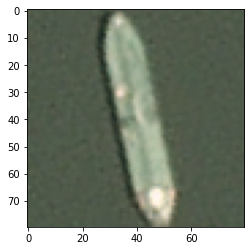

In [4]:
# llevar las imagenes aplanadas a 80x80x3
data = np.array(dataset['data']).astype('uint8')
data = data.reshape(-1,3,80,80).transpose([0,2,3,1])
labels =  np.array(dataset['labels'])

print(f"Dimensión: {data.shape}")

# ejemplos
plt.imshow(data[51])

In [5]:
 plt.figure(figsize=(10,3))

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

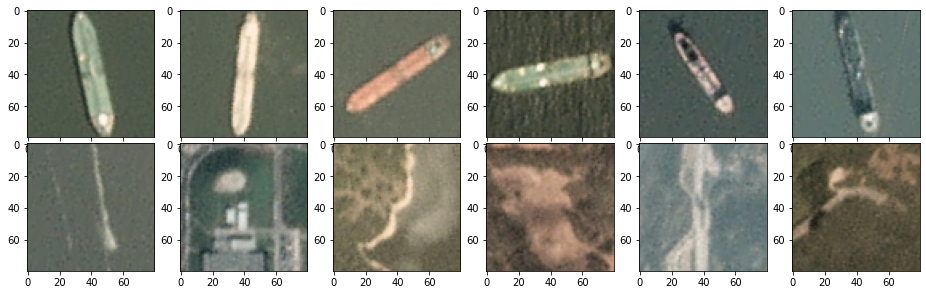

In [6]:
# ejemplos
f = plt.figure(figsize=(16,9))
for i in range(1,7):
    ax = f.add_subplot(2,6,i)
    ax.imshow(data[50+i])
for i in range(1,7):
    ax = f.add_subplot(1,6,i)
    ax.imshow(data[-1-i])

Dimensión: (4000, 80, 80)


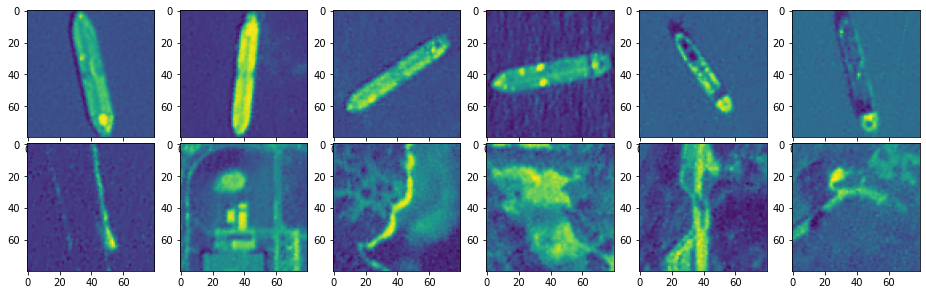

In [7]:
# llevamos las imágenes RGB a escala de grises
data_gray = np.array([color.rgb2gray(i) for i in data])
print(f"Dimensión: {data_gray.shape}")
# ejemplos
f = plt.figure(figsize=(16,9))
for i in range(1,7):
    ax = f.add_subplot(2,6,i)
    ax.imshow(data_gray[50+i])
for i in range(1,7):
    ax = f.add_subplot(1,6,i)
    ax.imshow(data_gray[-1-i])

# B. Extracción de características

## Histograms of Gradients (HoG) (lectura opcional)

EL histograma de orientación de gradiente (HoG) es un descriptor de características usado en visión por computadora y procesamiento de imágenes para la detección de objetos. Su utilidad viene dada de que la magnitud del gradiente es grande alrededor de los bordes y esquinas (regiones con cambios abruptos de itensidad), donde los arcos y esquinas contienen mucha más información sobre la forma del objeto que las regiones planas.

Sea $I_{i,j}$ la intensidad del pixel $(i,j)$, luego la magnitud del gradiente y su orientación viene dada por la siguiente expresión:

\begin{align}
& g = \sqrt{g_x^2+g_y^2}, g_x = I_{i,j}-I_{i-1,j}, g_y = I_{i,j}-I_{i,j-1}\\
& \theta = \text{arctan}\frac{gx}{gy}
\end{align}


Así el output inicial del procedemiento son dos matrices, una matriz que contiene la magnitud del gradiente de cada pixel y otra con la orientación del gradiente. Para convertir estas matrices a un vector se utilizará un histograma, por ejemplo, podemos dividir el dominio de las orientaciones en 9 bins de 20° (180° total, no son 360° ya que las transiciones de negro a blanco y de blanco a negro se consideran equivalentes), obteniéndose así un vector de dimensión 9, es decir, [0, 20, 40, 60, 80, 100, 120, 140, 160]. Luego cada pixel de una imágen votará en estos bins en base a la magnitud de gradiente que posee y su cercanía a los bins según su orientación, por ejemplo, si tenemos un pixel con ángulo 10° y magnitud 4, este sumára 2 al bin 0° y 2 al bin 20° pues se encuentra justo a la mitad de ambos, por otro lado, si tenemos un pixel con ángulo 80° y magnitud 2 este sumará solo al bin 80°. 

<img src="hog_histogram.png">

Para capturar de mejor forma información local de la imagen se suele dividir en zonas y calcular HoG en cada una de estas, siendo el vector resultante la concatenación de todos los histogramas. En el ejemplo a continuación la imágen se divide en 4x4 (16 submatrices, viene de dividir 80x80/(20x20)) y para cada zona se calcula HoG con 8 bins. 

Más detalle en:

- https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html?highlight=hog
- https://www.learnopencv.com/histogram-of-oriented-gradients/

In [8]:
# extrae hog features y hog transformation para cada imagen
ppc = 20
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc), cells_per_block=(1, 1),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)
hog_features = np.array(hog_features)
hog_images = np.array(hog_images)

hog_features.shape

(4000, 128)

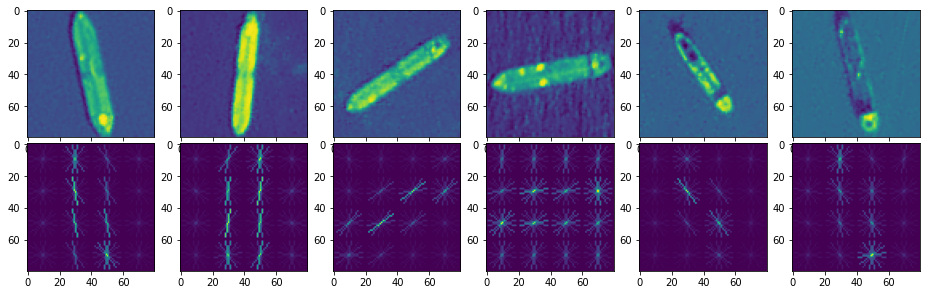

In [9]:
# ejemplos
f = plt.figure(figsize=(16,9))
for i in range(1,7):
    ax = f.add_subplot(2,6,i)
    ax.imshow(data_gray[50+i])
for i in range(1,7):
    ax = f.add_subplot(1,6,i)
    ax.imshow(hog_images[50+i])

# C. División en train-validation-test y métricas

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, train_size=.7, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=.5, random_state=9091997)

# D. Entrenamiento y evaluación

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class MyLogisticRegression:
    def __init__(self, eta=0.1, epochs=100):
        self.eta = eta
        self.epochs = epochs
        self.ll_train = []
        self.ll_val = []
        
    def fit(self, X, y):
        """
        En base al conjunto de entrenamiento D={X,y}, 
        despejar w y guardar en un atributo del objeto.
        """
        N, M = X.shape
        self.w = np.zeros(M)
        for epoch in range(self.epochs):
            if epoch%20==0:
                print('epoch:', epoch, ';', 'eta: {}'.format(self.eta))
            for i in range(N):
                gradient = (sigmoid(self.w @ X[i,:]) - y[i]) * X[i,:]
                self.w -= self.eta * gradient
            self.ll_train.append(self.log_verosimilitud(X_train, y_train))
            self.ll_val.append(self.log_verosimilitud(X_val, y_val))
        self.ll_train = np.array(self.ll_train)
        self.ll_val = np.array(self.ll_val)

    def predict(self, X):
        """
        Retorna las predicciones sobre X.
        """
        predictions = np.rint(sigmoid(self.w @ X.T))
        return predictions
    
    def log_verosimilitud(self, X, y):
        """
        Dado el vector de pesos w retorna la log-verosimilitud
        normalizada por el número de observaciones sobre D={X,y}
        """
        ll = (y @ np.log(sigmoid(self.w @ X.T)) + (1 - y) * np.log(1 - sigmoid(self.w @ X.T))).sum()
        ll /= len(y)
        return ll

In [13]:
def test(eta):
    log_reg = MyLogisticRegression(eta=eta, epochs=100)
    log_reg.fit(X_train, y_train)
    return log_reg.ll_train, log_reg.ll_val

etas = [0.01, 0.05, 0.1]
p = Pool(3)
results = p.map(test, etas)
p.close()
p.join()

epoch:epoch:epoch:   000  ; ; ;  eta: 0.05eta: 0.01eta: 0.1


epoch: 20epoch:  ;epoch:20   eta: 0.120
;  eta: 0.05;
 eta: 0.01
epoch: 40 epoch:; 40  ; epoch:eta: 0.01
eta: 0.05 
40 ; eta: 0.1
epoch:epoch:  60 60; eta: 0.05
 ; eta: 0.1
epoch: 60 ; eta: 0.01
epoch: 80 ; eta: 0.05
epoch: 80 ; eta: 0.1epoch: 
80 ; eta: 0.01


In [14]:
(train1, val1), (train2, val2), (train3, val3) = results
epochs = [i for i in range(1,101)]

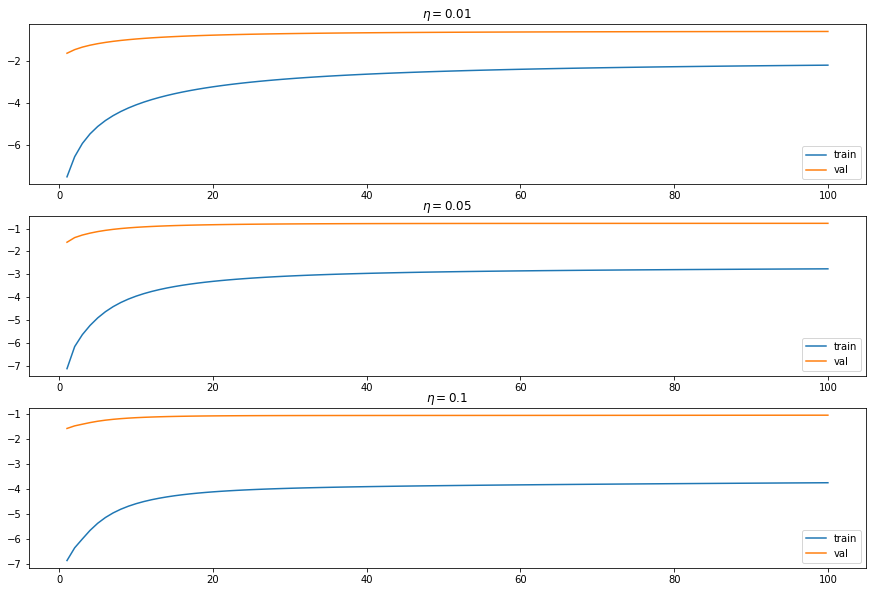

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))

ax[0].plot(epochs, train1 / 100)
ax[0].plot(epochs, val1 / 100)
ax[0].set_title('$\eta=0.01$')
ax[0].legend(['train', 'val'])

ax[1].plot(epochs, train2 / 100)
ax[1].plot(epochs, val2 / 100)
ax[1].set_title('$\eta=0.05$')
ax[1].legend(['train', 'val'])

ax[2].plot(epochs, train3 / 100)
ax[2].plot(epochs, val3 / 100)
ax[2].set_title('$\eta=0.1$')
ax[2].legend(['train', 'val'])


In [18]:
class MyFLDA:
    def fit(self, X, y):
        """
        En base al conjunto de entremamiento D={X,y},
        despejar a y b y guardar los atributos del objeto
        """
        mu_1 = X[y==0,:].mean(axis=0)
        mu_2 = X[y==1,:].mean(axis=0)
        self.S_w = (X.T - y) @ (X.T - y).T
        S_w_inv = np.linalg.inv(self.S_w)
        
        mu_subtraction = mu_1 - mu_2
        
        a = S_w_inv @ mu_subtraction
        b = - a.T @ (mu_1 + mu_2) / 2
        
        self.a = a
        self.b = b
        
    def predict(self, X):
        """
        Retorna las predicciones sobre X.
        """
        v = self.a @ X.T
        predictions = np.ones(v.shape)
        predictions[v >= -self.b] = 0

        return predictions

In [30]:
LogisticR = MyLogisticRegression(eta=0.1)
LogisticR.fit(X_train, y_train)
y_logistic = LogisticR.predict(X_test)

flda = MyFLDA()
flda.fit(X_train, y_train)
y_flda = flda.predict(X_test)

epoch: 0 ; eta: 0.1
epoch: 20 ; eta: 0.1
epoch: 40 ; eta: 0.1
epoch: 60 ; eta: 0.1
epoch: 80 ; eta: 0.1


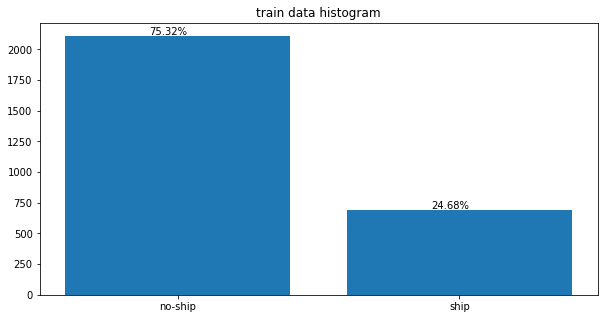

In [20]:
def histogram(data, title=None, *args, **kwargs):
    _, y = np.unique(data, return_counts=True)
    plt.figure(*args, **kwargs)
    if title!=None:
        plt.title(title)
    plt.bar(["no-ship","ship"], y)
    p_no_ship = y[0] / y.sum()
    p_ship = y[1] / y.sum()
    plt.text(-.1, y[0] + 10, '{:.2f}%'.format(p_no_ship * 100))
    plt.text(-.1 + 1, y[1] + 10, '{:.2f}%'.format(p_ship * 100))
    plt.show()
    return

histogram(y_train, title='train data histogram', figsize=(10,5))

In [22]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    créditos: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [23]:
cm_log = confusion_matrix(y_test, y_logistic)
cm_flda = confusion_matrix(y_test, y_flda)

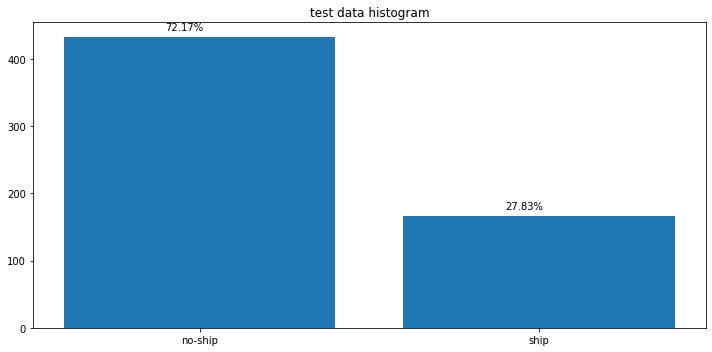

In [26]:
histogram(y_test,title='test data histogram', figsize=(10, 5), tight_layout=True)

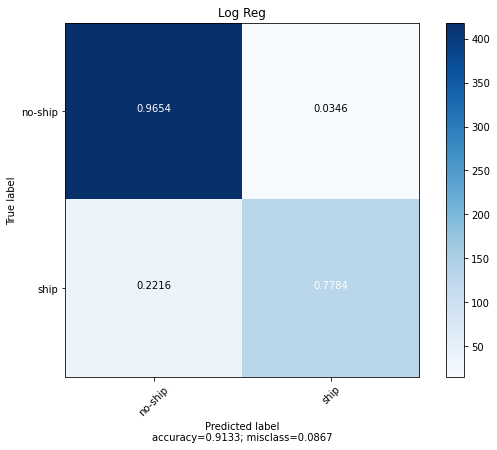

In [24]:
plot_confusion_matrix(cm_log, ['no-ship', 'ship'], title='Log Reg')

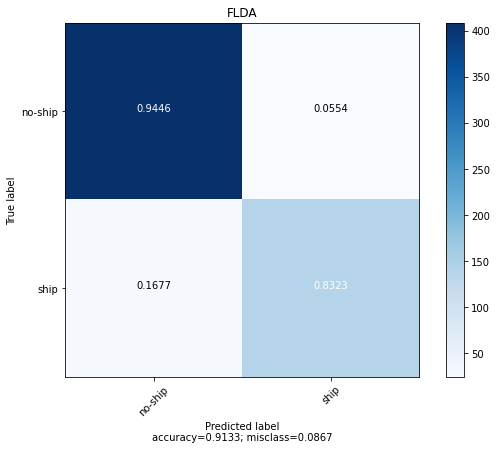

In [25]:
plot_confusion_matrix(cm_flda, ['no-ship', 'ship'], title='FLDA')